# import and constant

In [1]:
%pip install tensorflow tf2onnx matplotlib numpy opencv-python

  Using cached tensorflow-2.20.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
  Using cached numpy-2.3.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.32.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.

In [2]:
%pip install --upgrade --force-reinstall numpy h5py tensorflow

  Using cached numpy-2.3.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached h5py-3.14.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached tensorflow-2.20.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached protobuf-6.32.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-non

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import string

In [7]:
dataset_dir = './dataset'
model_name = 'sign_classifier'

In [ ]:
!curl -L -o ./alfabet-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/achmadnoer/alfabet-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  114M  100  114M    0     0  1054k      0  0:01:51  0:01:51 --:--:-- 1683k0  1019k      0  0:01:55  0:00:52  0:01:03  585k6 1321k:01:45  0:00:09 1371k3k      0  0:01:51  0:01:50  0:00:01 1648k


In [ ]:
!unzip ./alfabet-bisindo.zip -d .

Archive:  ./alfabet-bisindo.zip
  inflating: ./Citra BISINDO/A/body dot (1).jpg  
  inflating: ./Citra BISINDO/A/body dot (2).jpg  
  inflating: ./Citra BISINDO/A/body dot (3).jpg  
  inflating: ./Citra BISINDO/A/body dot (4).jpg  
  inflating: ./Citra BISINDO/A/body white (1).jpg  
  inflating: ./Citra BISINDO/A/body white (2).jpg  
  inflating: ./Citra BISINDO/A/body white (3).jpg  
  inflating: ./Citra BISINDO/A/body white (4).jpg  
  inflating: ./Citra BISINDO/A/wall white (1).jpg  
  inflating: ./Citra BISINDO/A/wall white (2).jpg  
  inflating: ./Citra BISINDO/A/wall white (3).jpg  
  inflating: ./Citra BISINDO/A/wall white (4).jpg  
  inflating: ./Citra BISINDO/B/body dot (1).jpg  
  inflating: ./Citra BISINDO/B/body dot (2).jpg  
  inflating: ./Citra BISINDO/B/body dot (3).jpg  
  inflating: ./Citra BISINDO/B/body dot (4).jpg  
  inflating: ./Citra BISINDO/B/body white (1).jpg  
  inflating: ./Citra BISINDO/B/body white (2).jpg  
  inflating: ./Citra BISINDO/B/body white (3).jp

In [ ]:
!mv "Citra BISINDO" ./dataset

# Train

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

Found 312 images belonging to 26 classes.


In [ ]:
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False,
    input_shape=(224, 224, 3) 
    )

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 708ms/step - accuracy: 0.1553 - loss: 3.3555
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.4688 - loss: 2.2259
Epoch 3/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 757ms/step - accuracy: 0.6808 - loss: 1.4438
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8125 - loss: 0.8361
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 746ms/step - accuracy: 0.8490 - loss: 0.6265
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.8750 - loss: 0.4333
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 723ms/step - accuracy: 0.9330 - loss: 0.3015
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.9375 - loss: 0.1830
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 695ms/step - accuracy: 0.9565 - loss: 0.1813
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.9688 - loss: 0.1036


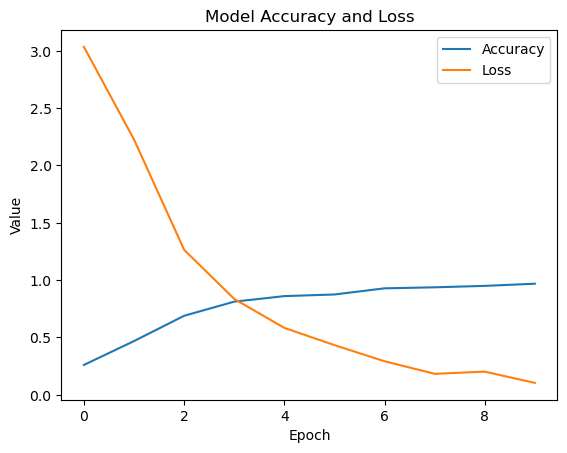

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Accuracy', 'Loss'])
plt.show()

# save model

In [ ]:
model.save(f"{model_name}.keras")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite file
with open(f"{model_name}.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmp1dn1ql57/assets


INFO:tensorflow:Assets written to: /var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmp1dn1ql57/assets


Saved artifact at '/var/folders/w3/12vhw4l144v3jqftz9jdh2cc0000gn/T/tmp1dn1ql57'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_479')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  13089692112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13064322512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13064321552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13064322320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13064317520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13064322704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13398033808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13398034000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13398033616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13398032464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13398

W0000 00:00:1760320404.980820 24595095 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1760320404.980844 24595095 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


# test model

In [8]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=f"{model_name}.tflite")
interpreter.allocate_tensors()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
# Get input & output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape'][1:3]  # (224, 224)

In [10]:
# List of labels A-Z
labels = list(string.ascii_uppercase)

In [13]:
from IPython.display import display, clear_output
import cv2
import numpy as np
from PIL import Image

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.resize(frame, (224, 224))
    input_data = np.expand_dims(img.astype(np.float32) / 255.0, axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    pred = np.argmax(output)
    cv2.putText(frame, f"Pred: {pred}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    clear_output(wait=True)
    display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

cap.release()

KeyboardInterrupt: 

In [14]:
cap.release()